In [4]:
import pandas as pd
from google.colab import files 
uploaded = files.upload()

Saving secom.data to secom.data


In [5]:
uploaded2 = files.upload()

Saving secom_labels.data to secom_labels.data


In [6]:
import io

In [7]:
df = pd.read_csv(io.BytesIO(uploaded['secom.data']), sep = ' ', header = None )
label = pd.read_csv(io.BytesIO(uploaded2['secom_labels.data']), sep = ' ', header = None )[0]

In [8]:
col_candidate = []
#COl 기준 std가 0이면 제외하기
for idx, val in zip(df.columns, df.describe().iloc[2]):
  if val != 0:
    col_candidate.append(idx)
df = df[col_candidate]
print(len(col_candidate))

474


In [9]:
#COl 기준 데이터의 수가 55% 미만인 것만 살리기
col_candidate = []
for idx, val in zip(df.columns, df.describe().iloc[0]):
  if val >= 700:
    col_candidate.append(idx)
df = df[col_candidate]
print(len(col_candidate))

450


In [10]:
pip install impyute

In [14]:
'''
#변환
from impyute.imputation.cs import mice
np_imputed = mice(df.values) # mice 학습시작
df_imputed = pd.DataFrame(np_imputed)
'''

'\n#변환\nfrom impyute.imputation.cs import mice\nnp_imputed = mice(df.values) # mice 학습시작\ndf_imputed = pd.DataFrame(np_imputed)\n'

In [16]:
import copy
data_with_label = copy.deepcopy(df)
data_with_label['Class'] = label

In [19]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(data_with_label)
data_with_label_imputed = pd.DataFrame(imputed, columns=data_with_label.columns)

In [11]:
from scipy import stats

In [20]:
sus = data_with_label_imputed[data_with_label_imputed.Class == -1]
fail = data_with_label_imputed[data_with_label_imputed.Class == 1]

In [24]:
import numpy as np
import scipy

p_results = []
columns = []
for i in data_with_label_imputed .columns:
  if i == len(data_with_label_imputed .columns):
    break
  else:
    sus_array = np.array(sus[i])
    fail_array = np.array(fail[i])
    if stats.bartlett(sus_array, fail_array)[1] < 0.05:
        p_results.append(scipy.stats.ttest_ind(sus_array, fail_array, equal_var=False)[1])
        columns.append(i)
    else:
        p_results.append(scipy.stats.ttest_ind(sus_array, fail_array, equal_var=True)[1])
        columns.append(i)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2241: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2241: RuntimeWarning: invalid value encountered in double_scalars
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


In [25]:
count = 0
for i in p_results:
  if i < 0.05:
    count += 1
print(count)

81


In [52]:
columnname_with_pvalue = pd.DataFrame(columns)
columnname_with_pvalue[1] = p_results

In [59]:
final = columnname_with_pvalue[1] < 0.05
final_data = columnname_with_pvalue[final]
list_ = np.array(final_data.loc[:,0])
real_final = data_with_label_imputed[list_]

In [60]:
real_final

,4,14,19,21,28,31,40,56,58,59,63,64,70,76,79,90,95,100,103,117,121,122,123,124,125,126,127,129,130,133,140,143,145,146,151,155,159,160,163,164,...,183,210,214,247,275,280,281,286,294,295,298,299,316,319,348,416,424,428,430,431,434,435,436,452,455,460,468,510,511,519,542,543,545,547,562,573,574,575,577,Class
0,1.3602,7.9558,12.5190,-5419.00,64.2333,3.5191,61.29,0.9317,4.7057,-1.7264,16.1445,21.7264,608.1700,-0.020600,-0.008300,8671.9301,0.0003,0.0002,-0.0042,58.4306,15.880000,2.639000,15.940000,15.930000,0.865600,3.353000,0.409800,-0.047300,0.7243,1000.726300,0.3948,0.0034,0.085000,0.035800,10.284000,0.41,1017.0,967.0,0.090,0.048,...,16.713,0.077200,0.070400,0.027200,0.1310,0.019700,0.012000,3.581100,418.1363,398.3185,0.0373,0.0202,6.2698,5.3737,0.021500,2.7380,2.4788,3.2750,18.7673,33.1562,10.0503,2.7073,3.1158,5.9396,2.3106,29.9394,311.6377,64.6707,0.0000,5.884167,0.1096,0.0078,7.1160,395.570,258.894000,0.3157,3.0624,0.1026,14.9509,-1.0
1,0.8294,10.1548,12.4608,-5441.50,68.4222,3.4171,78.25,0.9324,4.6820,0.8073,10.9036,19.1927,620.3582,-0.019800,-0.035800,8407.0299,0.0001,-0.0004,-0.0045,58.6680,15.880000,2.541000,15.910000,15.880000,0.870300,2.771000,0.413800,-0.094600,0.8122,998.108100,0.2301,0.0049,0.060000,0.054700,13.077000,0.35,568.0,59.0,0.112,0.115,...,16.358,0.056600,0.046800,0.184667,0.0767,0.017100,0.015400,3.948300,233.9865,26.5879,0.0502,0.0561,5.6522,5.2445,0.014200,3.9300,3.1531,2.8088,10.4383,2.2655,8.6336,5.7093,1.6779,5.1072,2.2568,40.4475,463.2883,141.4365,0.0000,40.014067,0.1096,0.0078,7.1160,408.798,252.776000,0.2653,2.0111,0.0772,10.9003,-1.0
2,1.5102,9.5157,12.5404,-5447.75,67.1333,3.5986,14.37,0.9139,4.5873,23.8245,11.3019,16.1755,625.9636,-0.032600,-0.005400,9317.1698,0.0002,0.0006,-0.0026,58.4808,15.900000,2.882000,15.940000,15.950000,0.879800,3.094000,0.477700,-0.189200,0.8194,998.444000,0.3263,0.0038,0.048300,0.061900,8.443000,0.47,562.0,788.0,0.187,0.117,...,22.912,0.033900,0.040100,0.172900,0.1117,0.015200,0.015700,2.549300,251.4536,329.6406,0.0800,0.0583,5.7247,6.1797,0.010500,3.0609,2.0261,3.7479,10.3162,29.1663,14.2503,5.7650,0.8972,4.8795,3.1182,32.3594,21.3645,240.7767,244.2748,36.906700,0.1096,0.0078,7.1160,411.136,267.064000,0.1882,4.0923,0.0640,9.2721,1.0
3,1.3204,9.6052,12.4782,-5468.25,62.9333,3.3813,76.90,0.9139,4.5873,24.3791,13.5597,15.6209,625.2945,-0.046100,0.067600,8205.7000,0.0002,-0.0002,-0.0059,58.6635,15.550000,3.132000,15.610000,15.590000,1.366000,2.480000,0.517600,0.283800,0.7244,980.451000,0.1915,0.0030,0.039300,0.061300,15.241000,0.35,859.0,355.0,0.068,0.108,...,22.562,0.124800,0.070800,0.019100,0.0581,0.011500,0.017200,4.052600,415.5048,157.0889,0.0285,0.0445,5.4440,6.3329,0.040700,2.4643,3.6091,2.8049,15.7089,13.4051,5.1760,5.3899,1.3671,4.4680,3.0744,27.6824,24.2831,113.5593,0.0000,4.120000,0.1096,0.0078,7.1160,372.822,268.228000,0.1738,2.8971,0.0525,8.5831,-1.0
4,1.5334,10.5661,12.4735,-5476.25,62.8333,3.2728,76.39,0.9298,4.6414,-12.2945,21.9782,32.2945,645.7636,0.018300,0.003400,9014.4600,-0.0001,0.0004,-0.0045,58.3858,15.750000,3.148000,15.730000,15.710000,0.946000,3.027000,0.532800,-0.567700,0.7780,993.127400,0.3744,0.0041,0.045100,0.062300,12.506000,0.43,699.0,283.0,0.147,0.040,...,37.715,0.091500,0.079700,0.029667,0.1092,0.011600,0.016300,3.653600,319.1252,128.0296,0.0755,0.0181,4.8956,11.0583,0.024600,3.3208,2.9734,3.4473,12.7642,10.7390,11.4064,2.0088,1.5533,4.3131,4.7756,30.8924,44.8980,148.0663,0.0000,6.379467,0.1096,0.0078,7.1160,399.914,257.113333,0.2224,3.1776,0.0706,10.9698,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,1.4843,11.7692,12.5373,-5418.75,71.1444,3.4680,81.21,0.9204,4.4941,2.8182,9.4918,17.1818,627.1100,-0.031333,0.008067,9201.7201,0.0000,0.0000,-0.0094,58.3

In [ ]:
'''
p_results = []
for i in data_with_label_imputed .columns:
  if i == len(data_with_label_imputed .columns):
    break
  else:
    temp = data_with_label_imputed [[i, 'Class']]
    name = ['Feature', 'Class']
    temp.columns = name
    model = smf.ols(formula = "Class ~ Feature", data = temp) 
    result = model.fit() 
    p_results.append(result.pvalues)
'''

In [61]:
# 0~1사이 값으로 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
real_final = pd.DataFrame(data = scaler.fit_transform(real_final.values), columns = real_final.columns)

#표준화는 평균을 빼고 표준편차로 나누는거.. 이상치의 영향을 덜 받음..

In [63]:
data_with_label = copy.deepcopy(df)
data_with_label['Class']= label

is_one = data_with_label['Class'] == 1
is_minusone = data_with_label['Class'] == -1
pass_data = data_with_label[is_minusone]
fail_data = data_with_label[is_one]

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

after_knn = copy.deepcopy(real_final)
after_knn['Class']= label
X = after_knn.drop(['Class'], axis=1)
y = after_knn['Class']

rfc = RandomForestClassifier(random_state=101)
selector = RFECV(estimator = rfc, step = 1, cv=StratifiedKFold(3), scoring='accuracy')
selector.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features: 79


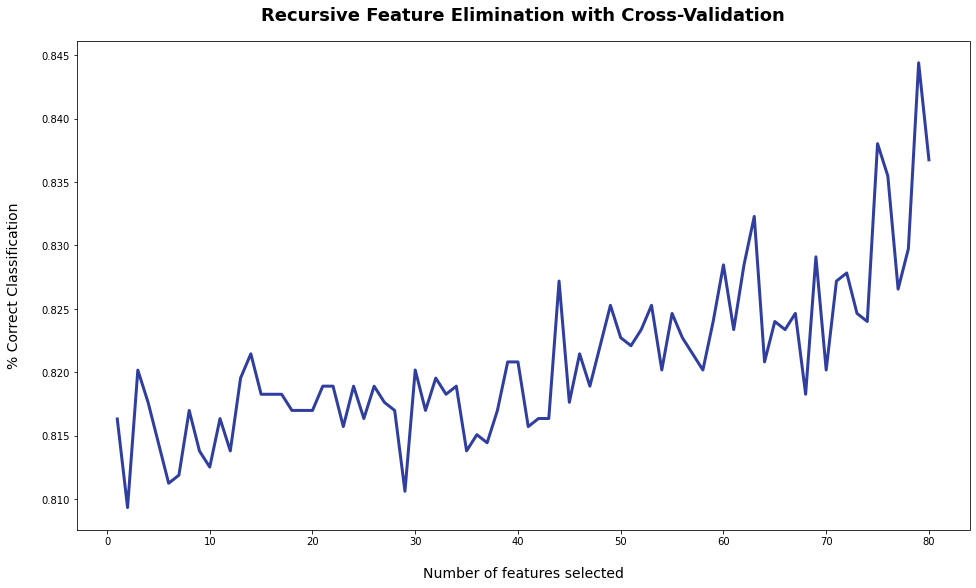

In [65]:
print('Optimal number of features: {}'.format(selector.n_features_))
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [69]:
selector.support_
ranking_list = selector.ranking_
print(ranking_list)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1]


In [70]:
!pip install imblearn
data = real_final.values
X, y = data[:, :-1], data[:, -1]
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [87]:
from sklearn.model_selection import train_test_split
train_data = pd.DataFrame(X_resampled)
target_data = pd.DataFrame(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, stratify=target_data, random_state = 1)

In [90]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1755, 80) (732, 80) (1755, 1) (732, 1)


In [91]:
# train set 을 train set/validation set으로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, random_state = 1)
# stratify : 지정한 Data의 비율을 유지.
# 예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때,
# stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할됨.

In [92]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1404, 80) (732, 80) (351, 80) (1404, 1) (732, 1) (351, 1)


In [101]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [30, 90, 100, 120],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [3, 5, 7, 8, 12],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9252


**모델 고르기 (1)Random Forest**

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

model = RandomForestClassifier(max_depth = 12, min_samples_leaf = 3, min_samples_split = 8, n_estimators = 100)
model.fit(X_train,y_train)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = accuracy_score(y_train, pred_train)
val_score = accuracy_score(y_val, pred_val)

print("train set의 예측 결과 : {}, validation set의 예측 결과 : {}".format(train_score, val_score))

pred_test = model.predict(X_test)
test_score = accuracy_score(y_test, pred_test)
print("최종 평가 (test set 이용) : {}".format(test_score))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


train set의 예측 결과 : 0.9950142450142451, validation set의 예측 결과 : 0.9373219373219374
최종 평가 (test set 이용) : 0.9357923497267759


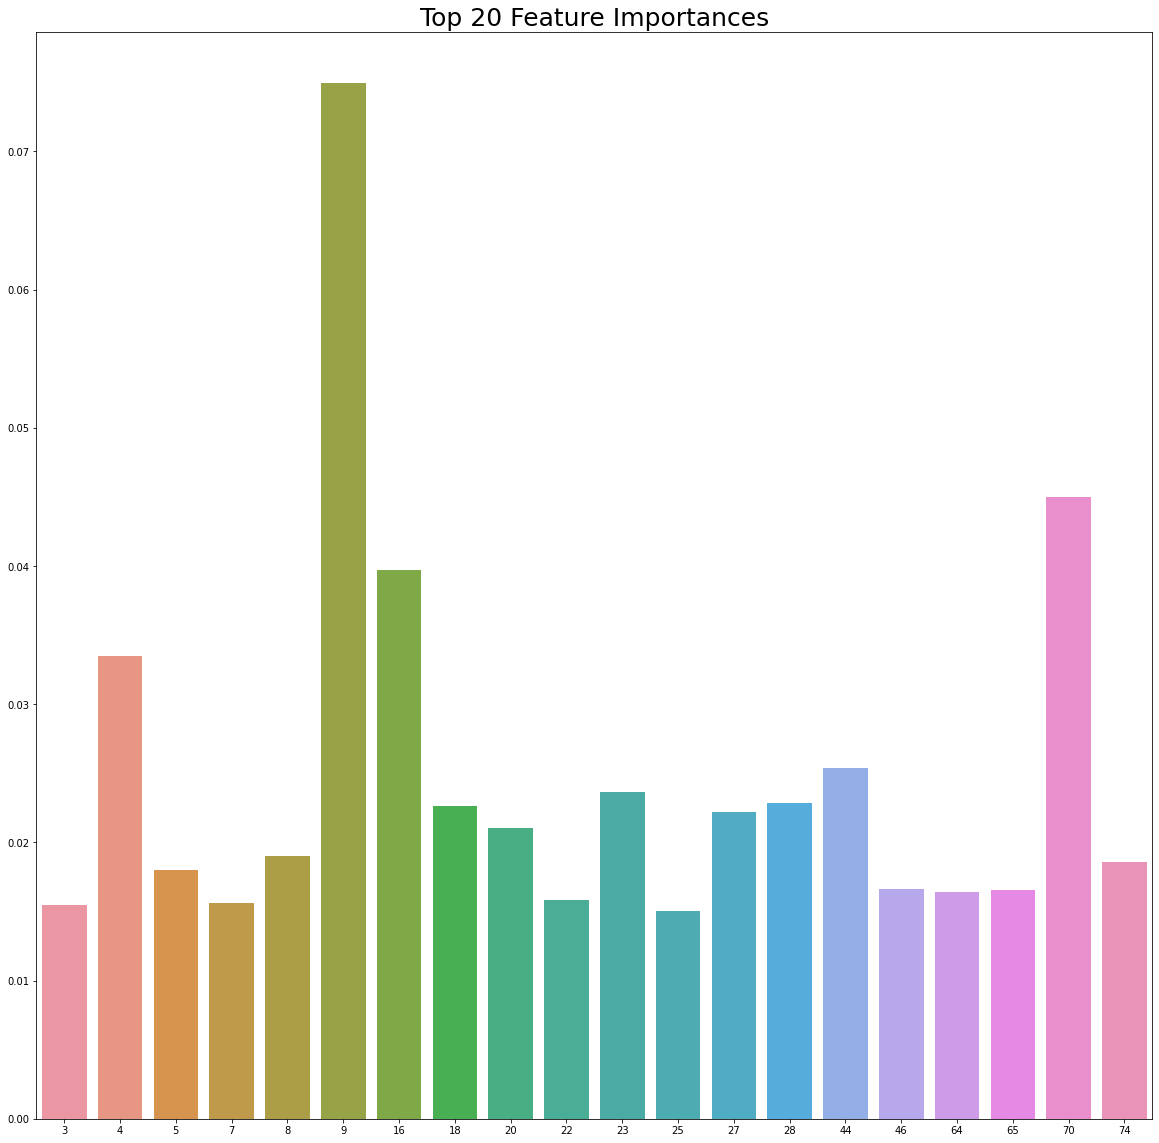

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(20,20))
plt.title('Top 20 Feature Importances', fontsize=25)
sns.barplot(x=ftr_top20.index, y=ftr_top20)
plt.show()

**모델 고르기 (2)K-Nearest Neighbor**

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

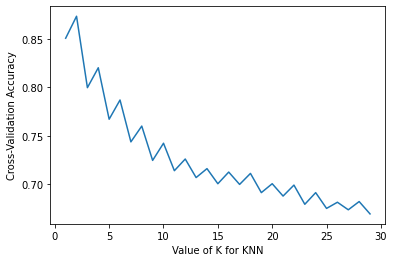

In [112]:
from sklearn import neighbors
from matplotlib.colors  import ListedColormap
from sklearn.model_selection import cross_val_score


k_range = range(1,30)              # k를 1~100까지 고려하여 최적의 k를 찾을 것이다.
k_scores = []                        # 각 k들의 성능을 비교하기 위한 리스트생성이다.

for k in k_range :
   knn = neighbors.KNeighborsClassifier(k)
   scores = cross_val_score(knn,X_train,y_train, cv=10, scoring = "accuracy")    # 10-fold cross-validation
   k_scores.append(scores.mean())

import matplotlib.pyplot as plt
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

In [117]:
max_score = 0
opt_num = 0
for num, score in enumerate(k_scores):
  if max_score <score:
    max_score = score
    opt_num = num
print(opt_num) 

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

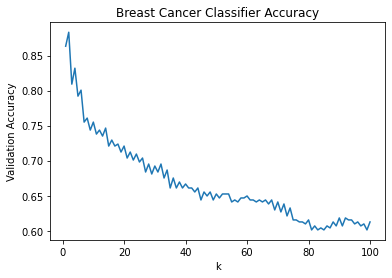

In [119]:
k_list = range(1,101)
accuracies = []
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train, y_train)
  accuracies.append(classifier.score(X_val, y_val))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Breast Cancer Classifier Accuracy")
plt.show()

In [118]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)

pred_train_knn = classifier.predict(X_train)
pred_val_knn = classifier.predict(X_val)

train_score_knn = accuracy_score(y_train, pred_train_knn)
val_score_knn = accuracy_score(y_val, pred_val_knn)

print("train set의 예측 결과 : {}, validation set의 예측 결과 : {}".format(train_score_knn, val_score_knn))

pred_test_knn = classifier.predict(X_test)
test_score_knn = accuracy_score(y_test, pred_test_knn)
print("최종 평가 (test set 이용) : {}".format(test_score_knn))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


train set의 예측 결과 : 1.0, validation set의 예측 결과 : 0.8632478632478633
최종 평가 (test set 이용) : 0.8579234972677595
